# Imports

In [1]:
import matplotlib
from google.colab import runtime

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

if matplotlib.__version__ == '3.2.2':
    # Se necesita la versión 3.5.1 que soporta float16 para pintar kanji
    !pip install -U matplotlib

    print('Stopping RUNTIME! Please run again.')
    quit()
    # https://twitter.com/GoogleColab/status/1569389018311426051

matplotlib: 3.5.3


In [2]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.4 MB/s eta 0:00:00
time: 352 µs (started: 2023-02-26 13:09:12 +00:00)


In [3]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense, 
    Dropout, Input, Concatenate, GlobalAveragePooling2D
)
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 3.68 s (started: 2023-02-26 13:09:12 +00:00)


In [4]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 881
ETL_DATASET = 'etl_8G'
DNN_NAME = 'ResNet152V2'

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'regular' 

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/' \
            + TYPE_IMG +'_otsu/'

print(ROOT_PATH)
print()
print('versión Keras:', keras.__version__)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_{}/splits/regular_otsu/

versión Keras: 2.11.0
time: 2.78 ms (started: 2023-02-26 13:09:15 +00:00)


In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 28.8 s (started: 2023-02-26 13:09:15 +00:00)


# Funciones

In [6]:
def load_images_for_training(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for training and validation images
    '''
    if TYPE_IMG == 'regular':
        train_name_img = 'train_imgs_8G.npz'
        train_name_labels = 'train_labels_8G.npz'
        val_name_img = 'val_imgs_8G.npz'
        val_name_labels = 'val_labels_8G.npz'
    elif TYPE_IMG == 'inverted':
        train_name_img = 'train_inv_imgs_8G.npz'
        train_name_labels = 'train_inv_labels_8G.npz'
        val_name_img = 'val_inv_imgs_8G.npz'
        val_name_labels = 'val_inv_labels_8G.npz'

    train_images = np.load(PATH+train_name_img)['arr_0']
    train_labels = np.load(PATH+train_name_labels)['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+val_name_img)['arr_0']
    val_labels = np.load(PATH+val_name_labels)['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for testing images
    '''

    if TYPE_IMG == 'regular':
        test_name_img = 'test_imgs_8G.npz'
        test_name_labels = 'test_labels_8G.npz'
    elif TYPE_IMG == 'inverted':
        test_name_img = 'test_inv_imgs_8G.npz'
        test_name_labels = 'test_inv_labels_8G.npz'

    test_images = np.load(PATH+test_name_img)['arr_0']
    test_labels = np.load(PATH+test_name_labels)['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL):

    image_input = Input(shape=(WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL))
    img_conc = Concatenate()([image_input, image_input, image_input])

    m_Resnet152V2_8G = keras.applications.ResNet152V2(
        include_top=False,
        input_tensor=img_conc,
        weights='imagenet',
    )

    last_layer = m_Resnet152V2_8G.layers[-1].output
    x = GlobalAveragePooling2D()(last_layer)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
    custom_model = Model(image_input, out)

    # freeze all the layers except the 2 newly added layers
    for layer in custom_model.layers[:-2]:
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
        # verbose = 1,
        # batch_size=32
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time: ")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    #-----------------------------------------------------------
    # Recuperar una lista de resultados de la lista de datos de los conjuntos de entrenamiento y pruebas para cada epoch de entrenamiento
    #-----------------------------------------------------------

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


def save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG,
               USE_DATA_AUG, DNN_NAME, ETL_DATASET):
    '''Guardar el modelo en disco duro.
    Debe especificarse la ruta porque por defecto la guarda
    en el la memoria de la misma instancia de Google Colab.
    
    Args:
        - SIZE: 64, 96, 112 ó 127
        - TFM_PATH = Ruta en drive a la carpeta del TFM
        - custom_model = Modelo de Deep Learning
        - TYPE_IMG = regular o inverted
        - USE_DATA_AUG = sin_DA o con_DA
        - DNN_NAME= Deep Neural Network's name, like ResNet152V2.
    '''
    MODEL_NAME = f'model_{DNN_NAME.lower()}_{ETL_DATASET.lower()}_imgs{SIZE}_' \
                + TYPE_IMG +'__OTSU.h5'

    WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG + '/' + TYPE_IMG + '/otsu_reg/' + MODEL_NAME

    custom_model.save(WEIGHTS_PATH)
    print(f'------ Model Saved in {WEIGHTS_PATH}')


time: 7.92 ms (started: 2023-02-26 13:09:44 +00:00)


# Imgs 64x64

- Test Accuracy: 0.6598984599113464
- Test Loss: 1.6846585273742676
- time: 1h 10min 47s
- F1 score: 0.6606718441200389
- Precision score: 0.6791657585884331
- Recall:  0.6598984771573604
- Epoch: 50/50



## Cargar la imágenes

In [8]:
SIZE = 64  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_64/splits/regular_otsu/
time: 1.1 ms (started: 2023-02-26 13:10:19 +00:00)


In [9]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 4.75 s (started: 2023-02-26 13:10:19 +00:00)


In [10]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (106380, 64, 64, 1) and labels: (106380,)

- val images: (21276, 64, 64, 1) and labels: (21276,)


time: 1.18 ms (started: 2023-02-26 13:10:24 +00:00)


## Preparar el modelo

In [11]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

234545216/234545216 [==============================] - 1s 0us/step
time: 9.33 s (started: 2023-02-26 13:10:24 +00:00)


In [12]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 3)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['concatenate[0][0]']            
                                                                                              

## Entrenar modelo

In [13]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 104s 26ms/step - loss: 5.5243 - sparse_categorical_accuracy: 0.1152 - val_loss: 4.8086 - val_sparse_categorical_accuracy: 0.2187
Epoch 2/50
3325/3325 [==============================] - 84s 25ms/step - loss: 4.3241 - sparse_categorical_accuracy: 0.3093 - val_loss: 4.1419 - val_sparse_categorical_accuracy: 0.3195
Epoch 3/50
3325/3325 [==============================] - 84s 25ms/step - loss: 3.7182 - sparse_categorical_accuracy: 0.4023 - val_loss: 3.7228 - val_sparse_categorical_accuracy: 0.3748
Epoch 4/50
3325/3325 [==============================] - 88s 26ms/step - loss: 3.2972 - sparse_categorical_accuracy: 0.4630 - val_loss: 3.4203 - val_sparse_categorical_accuracy: 0.4169
Epoch 5/50
3325/3325 [==============================] - 84s 25ms/step - loss: 2.9783 - sparse_categorical_accuracy: 0.5120 - val_loss: 3.1868 - val_sparse_categorical_accuracy: 0.4487
Epoch 6/50
3325/3325 [==============================] - 83s 25ms/step - loss: 2

In [14]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 523 ms (started: 2023-02-26 14:21:23 +00:00)


In [15]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 11s 20ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.6598984599113464
- Test Loss: 1.6846585273742676
- time: 
- F1 score: 0.6606718441200389
- Precision score: 0.6791657585884331
- Recall:  0.6598984771573604
- Epoch: 
*********************************************************************************************************************************
time: 21.6 s (started: 2023-02-26 14:21:24 +00:00)


## Graficando

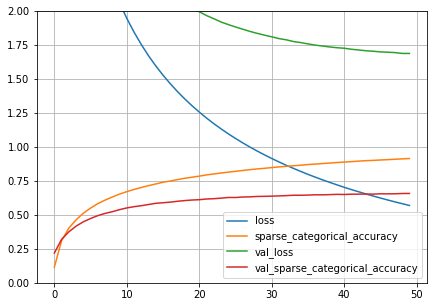

time: 272 ms (started: 2023-02-26 14:21:45 +00:00)


In [16]:
plot_loss(history)

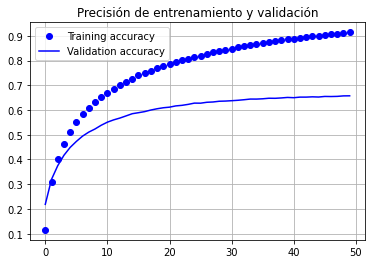

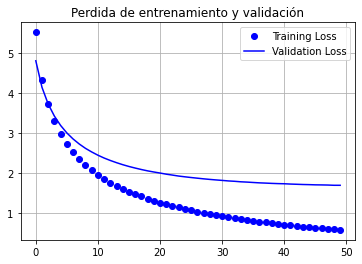

time: 248 ms (started: 2023-02-26 14:21:46 +00:00)


In [17]:
show_history(history)

In [18]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, ETL_DATASET)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet152V2/weights_resnet152v2/sin_DA/regular/otsu_reg/model_resnet152v2_etl_8g_imgs64_regular__OTSU.h5
time: 2.51 s (started: 2023-02-26 14:21:46 +00:00)


# Imgs 96x96

- Test Accuracy: 0.7586012482643127
- Test Loss: 1.2432359457015991
- time: 1h 21min 15s
- F1 score: 0.7592648369411857
- Precision score: 0.7739679498565396
- Recall:  0.7586012408347433
- Epoch: 50/50



## Cargar las imágenes

In [19]:
SIZE = 96  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_96/splits/regular_otsu/
time: 742 µs (started: 2023-02-26 14:21:49 +00:00)


In [20]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 4.64 s (started: 2023-02-26 14:21:49 +00:00)


In [21]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 96, 96, 1) and labels: (106380,)

- val images: (21276, 96, 96, 1) and labels: (21276,)

time: 1.38 ms (started: 2023-02-26 14:21:54 +00:00)


## Preparar el modelo

In [22]:
custom_model2 = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 4.48 s (started: 2023-02-26 14:21:54 +00:00)


In [23]:
print(custom_model2.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 96, 96, 3)    0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 102, 102, 3)  0           ['concatenate_1[0][0]']          
                                                                                            

## Entrenar modelo

In [24]:
history2 = train_model(custom_model2, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 106s 29ms/step - loss: 5.4965 - sparse_categorical_accuracy: 0.1241 - val_loss: 4.7441 - val_sparse_categorical_accuracy: 0.2417
Epoch 2/50
3325/3325 [==============================] - 95s 29ms/step - loss: 4.2452 - sparse_categorical_accuracy: 0.3337 - val_loss: 4.0296 - val_sparse_categorical_accuracy: 0.3579
Epoch 3/50
3325/3325 [==============================] - 97s 29ms/step - loss: 3.5958 - sparse_categorical_accuracy: 0.4476 - val_loss: 3.5566 - val_sparse_categorical_accuracy: 0.4344
Epoch 4/50
3325/3325 [==============================] - 97s 29ms/step - loss: 3.1380 - sparse_categorical_accuracy: 0.5211 - val_loss: 3.2137 - val_sparse_categorical_accuracy: 0.4804
Epoch 5/50
3325/3325 [==============================] - 97s 29ms/step - loss: 2.7884 - sparse_categorical_accuracy: 0.5741 - val_loss: 2.9478 - val_sparse_categorical_accuracy: 0.5187
Epoch 6/50
3325/3325 [==============================] - 97s 29ms/step - loss: 2

In [25]:
test_images2, test_labels2 = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 790 ms (started: 2023-02-26 15:43:17 +00:00)


## Métricas

In [26]:
show_metrics(custom_model2, test_images2, test_labels2)

444/444 [==============================] - 13s 23ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.7586012482643127
- Test Loss: 1.2432359457015991
- time: 
- F1 score: 0.7592648369411857
- Precision score: 0.7739679498565396
- Recall:  0.7586012408347433
- Epoch: 
*********************************************************************************************************************************
time: 24.9 s (started: 2023-02-26 15:43:18 +00:00)


## Graficando

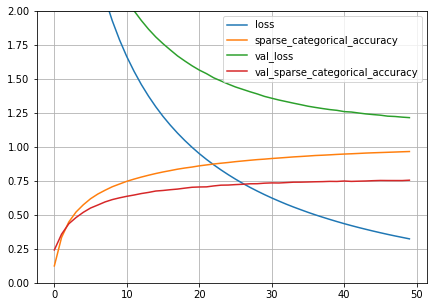

time: 169 ms (started: 2023-02-26 15:43:43 +00:00)


In [27]:
plot_loss(history2)

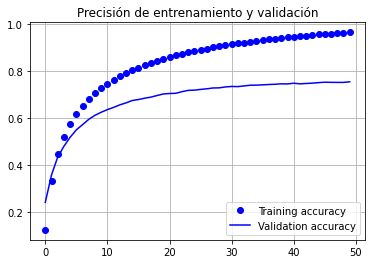

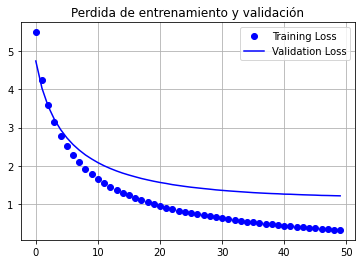

time: 569 ms (started: 2023-02-26 15:43:43 +00:00)


In [28]:
show_history(history2)

In [29]:
save_model(SIZE, TFM_PATH, custom_model2, TYPE_IMG, USE_DATA_AUG, DNN_NAME, ETL_DATASET)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet152V2/weights_resnet152v2/sin_DA/regular/otsu_reg/model_resnet152v2_etl_8g_imgs96_regular__OTSU.h5
time: 1.58 s (started: 2023-02-26 15:43:43 +00:00)


# Imgs 112x112

- Test Accuracy: 0.7612802982330322
- Test Loss: 1.125655174255371
- time: 1h 32min 1s
- F1 score: 0.7618341383195258
- Precision score: 0.7767760243141314
- Recall:  0.7612803158488438
- Epoch: 50/50




## Cargar imágenes

In [30]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_112/splits/regular_otsu/
time: 649 µs (started: 2023-02-26 15:43:45 +00:00)


In [31]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 5.53 s (started: 2023-02-26 15:43:45 +00:00)


In [32]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 112, 112, 1) and labels: (106380,)

- val images: (21276, 112, 112, 1) and labels: (21276,)

time: 1.38 ms (started: 2023-02-26 15:43:51 +00:00)


## Preparar el modelo

In [33]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 4.52 s (started: 2023-02-26 15:43:51 +00:00)


In [34]:
print(custom_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 112, 112, 3)  0           ['input_3[0][0]',                
                                                                  'input_3[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 118, 118, 3)  0           ['concatenate_2[0][0]']    

## Entrenar modelo


In [35]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 125s 35ms/step - loss: 5.0705 - sparse_categorical_accuracy: 0.1627 - val_loss: 4.1592 - val_sparse_categorical_accuracy: 0.2978
Epoch 2/50
3325/3325 [==============================] - 111s 33ms/step - loss: 3.5953 - sparse_categorical_accuracy: 0.4125 - val_loss: 3.3765 - val_sparse_categorical_accuracy: 0.4304
Epoch 3/50
3325/3325 [==============================] - 111s 33ms/step - loss: 2.9039 - sparse_categorical_accuracy: 0.5297 - val_loss: 2.9038 - val_sparse_categorical_accuracy: 0.4992
Epoch 4/50
3325/3325 [==============================] - 110s 33ms/step - loss: 2.4501 - sparse_categorical_accuracy: 0.6038 - val_loss: 2.5723 - val_sparse_categorical_accuracy: 0.5525
Epoch 5/50
3325/3325 [==============================] - 110s 33ms/step - loss: 2.1232 - sparse_categorical_accuracy: 0.6556 - val_loss: 2.3337 - val_sparse_categorical_accuracy: 0.5854
Epoch 6/50
3325/3325 [==============================] - 110s 33ms/step - lo

In [36]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 889 ms (started: 2023-02-26 17:15:59 +00:00)


In [37]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 14s 26ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.7612802982330322
- Test Loss: 1.125655174255371
- time: 
- F1 score: 0.7618341383195258
- Precision score: 0.7767760243141314
- Recall:  0.7612803158488438
- Epoch: 
*********************************************************************************************************************************
time: 27.3 s (started: 2023-02-26 17:16:00 +00:00)


## Graficando

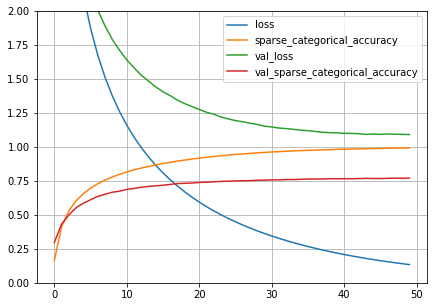

time: 150 ms (started: 2023-02-26 17:16:27 +00:00)


In [38]:
plot_loss(history)

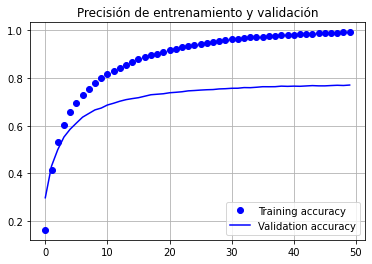

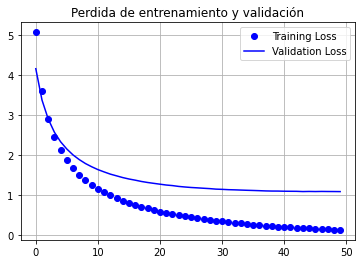

time: 252 ms (started: 2023-02-26 17:16:27 +00:00)


In [39]:
show_history(history)

In [40]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, ETL_DATASET)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet152V2/weights_resnet152v2/sin_DA/regular/otsu_reg/model_resnet152v2_etl_8g_imgs112_regular__OTSU.h5
time: 1.56 s (started: 2023-02-26 17:16:28 +00:00)


# Imgs 127x127

- Test Accuracy: 0.8121827244758606
- Test Loss: 0.9066899418830872
- time: 1h 44min 3s
- F1 score: 0.8129290620702728
- Precision score: 0.8258891831342142
- Recall:  0.8121827411167513
- Epoch: 50/50



## Cargar imágenes

In [41]:
SIZE = 127  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_127/splits/regular_otsu/
time: 694 µs (started: 2023-02-26 17:16:29 +00:00)


In [42]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 6.76 s (started: 2023-02-26 17:16:29 +00:00)


In [43]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 127, 127, 1) and labels: (106380,)

- val images: (21276, 127, 127, 1) and labels: (21276,)

time: 1.46 ms (started: 2023-02-26 17:16:36 +00:00)


## Preparar el modelo

In [44]:
custom_model2 = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 4.58 s (started: 2023-02-26 17:16:36 +00:00)


In [45]:
print(custom_model2.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 127, 127, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_3 (Concatenate)    (None, 127, 127, 3)  0           ['input_4[0][0]',                
                                                                  'input_4[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 133, 133, 3)  0           ['concatenate_3[0][0]']    

## Entrenar modelo

In [46]:
history2 = train_model(custom_model2, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 136s 38ms/step - loss: 4.8505 - sparse_categorical_accuracy: 0.1942 - val_loss: 3.8761 - val_sparse_categorical_accuracy: 0.3505
Epoch 2/50
3325/3325 [==============================] - 124s 37ms/step - loss: 3.2833 - sparse_categorical_accuracy: 0.4674 - val_loss: 3.0696 - val_sparse_categorical_accuracy: 0.4923
Epoch 3/50
3325/3325 [==============================] - 125s 37ms/step - loss: 2.5829 - sparse_categorical_accuracy: 0.5903 - val_loss: 2.5954 - val_sparse_categorical_accuracy: 0.5623
Epoch 4/50
3325/3325 [==============================] - 124s 37ms/step - loss: 2.1293 - sparse_categorical_accuracy: 0.6676 - val_loss: 2.2705 - val_sparse_categorical_accuracy: 0.6141
Epoch 5/50
3325/3325 [==============================] - 124s 37ms/step - loss: 1.8058 - sparse_categorical_accuracy: 0.7223 - val_loss: 2.0370 - val_sparse_categorical_accuracy: 0.6481
Epoch 6/50
3325/3325 [==============================] - 124s 37ms/step - lo

## Graficando

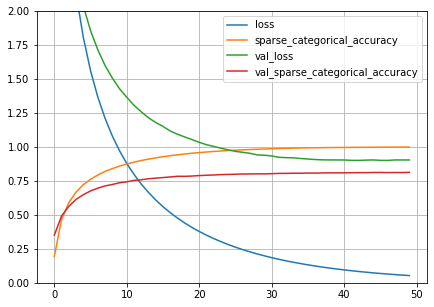

time: 150 ms (started: 2023-02-26 19:00:47 +00:00)


In [47]:
plot_loss(history2)

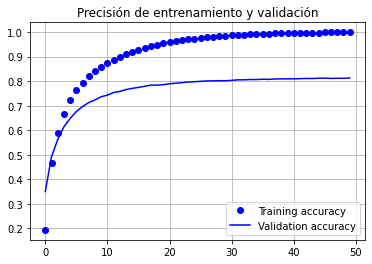

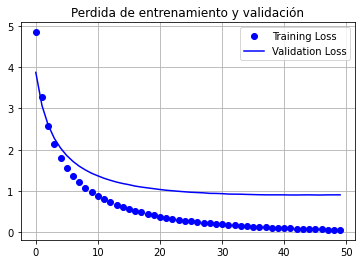

time: 277 ms (started: 2023-02-26 19:00:47 +00:00)


In [48]:
show_history(history2)

In [49]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, ETL_DATASET)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet152V2/weights_resnet152v2/sin_DA/regular/otsu_reg/model_resnet152v2_etl_8g_imgs127_regular__OTSU.h5
time: 1.59 s (started: 2023-02-26 19:00:47 +00:00)


## Métricas

In [50]:
test_images2, test_labels2 = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 988 ms (started: 2023-02-26 19:00:49 +00:00)


In [51]:
show_metrics(custom_model2, test_images2, test_labels2)

444/444 [==============================] - 16s 30ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.8121827244758606
- Test Loss: 0.9066899418830872
- time: 
- F1 score: 0.8129290620702728
- Precision score: 0.8258891831342142
- Recall:  0.8121827411167513
- Epoch: 
*********************************************************************************************************************************
time: 31.3 s (started: 2023-02-26 19:00:50 +00:00)


In [ ]:
runtime.unassign()